# LAB: Stochastic Gradient Descent SOLUTIONS

The objective of this lab session is to implement:
- Stochastic gradient descent with constant stepsizes
- Stochastic gradient descent with shrinking stepsizes
- Stochastic gradient descent with sampling with/without replacement
- Stochastic gradient descent with averaging 
- SAG, Stochastic average gradient descent

and compare your implementation with gradient descent.

Throughout the notebook you will find commented boxes like this one



In [2]:
### TODO ###   
# please implement blabla
#############

These boxes need to be replaced by code as explained in the boxes.
Solutions will online tomorrow. Good luck!

In [3]:
%matplotlib inline

In [4]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top w, b_i) + \frac \lambda 2 \|w\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(w)
$$
where
$$
f_i(w) = \ell(x_i^\top w, y_i) + \frac \lambda 2 \|w\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(w) = (x_i^\top w - y_i) x_i + \lambda w
$$
and
$$
\nabla f_i(w) = - \frac{y_i}{1 + \exp(y_i x_i^\top w)} x_i + \lambda w.
$$

Denote by $L$ the Lipschitz constant of $f$ and $X = [x_1, \ldots, x_n].$
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{n} + \lambda 
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{4 n} + \lambda 
$$
For full-gradient methods, the theoretical step-size is $1 / L$.

We now introduce a class that will be used for the solvers.

In [5]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    def grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w
# (1/n)X (X^Tw-y) + lbda*w
    def f(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
    
    def grad_i(self, i, w):
        x_i = self.X[i]
        return (x_i.dot(w) - self.y[i]) * x_i + self.lbda * w

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        return L

In [6]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    def grad(self, w):
        bAx = self.y * self.X.dot(w)
        temp = 1. / (1. + np.exp(bAx))
        grad = - (self.X.T).dot(self.y * temp) / self.n + self.lbda * w
        return grad

    def f(self, w):
#         bAx = (self.X.dot(w)).dot(self.y)
        bAx = self.y * self.X.dot(w)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(w) ** 2 / 2.
    
    def grad_i(self, i, w):
        grad = - self.X[i] * self.y[i] / (1. + np.exp(self.y[i] * self.X[i].dot(w)))
        grad += self.lbda * w
        return grad
    # \nabla f_i(w) = - \frac{y_i}{1 + \exp(y_i x_i^\top w)} x_i + \lambda w.

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = norm(self.X, ord=2) ** 2  / (4. * self.n) + self.lbda
        return L

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [7]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(w, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

In [8]:
def simu_logreg(w, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    X, y = simu_linreg(w, n, std=1., corr=0.5)
    return X, np.sign(y)

### Generate Data

In [57]:
d = 50
n = 1000
idx = np.arange(d)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

#X, y = simu_linreg(w_model_truth, n, std=1., corr=0.1)
X, y = simu_logreg(w_model_truth, n, std=1., corr=0.7)

In [62]:
type(X)

numpy.ndarray

In [16]:
### Choice of the model

In [17]:
lbda = 1. / n ** (0.5)
#model = LinReg(X, y, lbda)
model = LogReg(X, y, lbda)

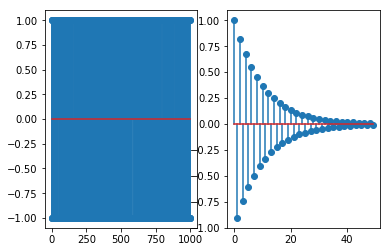

In [18]:
plt.subplot(1, 2, 1)
plt.stem(y); 
plt.subplot(1, 2, 2)
plt.stem(w_model_truth); 

In [19]:
from scipy.optimize import check_grad
modellog = LogReg(X, y, lbda)
# Check that the gradient and the loss numerically match
check_grad(modellog.f, modellog.grad, np.random.randn(d))

1.4503750157034571e-07

In [20]:
modellin = LinReg(X, y, lbda)
# Check that the gradient and the loss numerically match
check_grad(modellin.f, modellin.grad, np.random.randn(d))

2.5730737655256182e-06

### Find a highly accurate solution using LBFGS method

In [21]:
from scipy.optimize import fmin_l_bfgs_b

w_init = np.zeros(d)
w_min, obj_min, _ = fmin_l_bfgs_b(model.f, w_init, model.grad, args=(), pgtol=1e-30, factr =1e-30)

print(obj_min)
print(norm(model.grad(w_min)))

0.498017240818
2.2708487270051332e-09


<a id='constant'></a> 

## 3. Implementing Stochastic Gradient Descent


### SGD

We recall that an iteration of SGD writes



**for** $t = 1, \ldots, T$ 
  
$\qquad$ Pick $i$ uniformly at random in $\{1, \ldots, n\}$
   
$\qquad \displaystyle
x_{t+1} \gets x_t - \eta_t \nabla f_i(x_t)
$
  
**end for**



Complete the code below. The inputs are
- n_iter: The number of iterations
- indices: an np.array of indices of length n_iter. The indices[k]  is the index of stochastic gradient that will be used on the kth iteration. 
- steps: an np.array of positive floats of length n_iter. The steps[k] is the stepsize used on the kth iteration. Typically decreasing stepsizes are used $\eta_t = \frac{\eta_0}{\sqrt{t+1}}$, where $\eta_0$ is a step-size to be tuned by hand.

- averaging_on: is a boolean which indicates if the output should be the average of the iterates.

The outputs are:
- x_output: The final x vector found by the algorithm or the average  $ \bar{x} = \frac{1}{T-t}\sum_{i=t}^T x_t$ if averaging is on
- objectives: A ndarray containing the sequence function values calculated during the iterations of the algorithm 
- errors: If x_min is not empty, errors is a ndarray containing the sequence of errors || x - x_min || of the algorithm. Otherwise errors should be empty.
*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [22]:
def sgd(w0, model, indices, steps, w_min, n_iter=100, averaging_on=False ,verbose=True, start_late_averaging = 0):
    """Stochastic gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # average x
    w_average = w0.copy()
    w_test = w0.copy()
    # estimation error history
    errors = []
    err = 1.0
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w) 
    objectives.append(obj)
    if verbose:
        print("Lauching SGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter):
        w_new[:] = w - steps[k] * model.grad_i(indices[k],w)
        w[:] = w_new
        if k < start_late_averaging:
            w_average[:] = w
        else:    
            k_new = k-start_late_averaging
            w_average[:] = k_new / (k_new+1) * w_average + w / (k_new+1) # Calculating the average in the fly
            
        if averaging_on:
            w_test[:] = w_average
        else:
            w_test[:] = w
        obj = model.f(w_test) 
        if np.any(w_min):
            err = norm(w_test - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if k % n_samples == 0 and verbose:
            if(sum(w_min)):
                print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
            else:
                print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)]))
    if averaging_on:
        w_output = w_average.copy()
    else:
        w_output = w.copy()    
    return w_output, np.array(objectives), np.array(errors)

In [23]:
##Setup number of iterations
datapasses = 15  # number of sweeps through all the data. This means that there will datapasses*n stochastic gradient updates
niters = int(datapasses * n)

### SGD with constant step with replacement

In [24]:
indices = np.random.choice(n, niters + 1, replace=True)
steps = 0.005 * np.ones(niters + 1)
np.size(indices)
w0 = np.zeros(d)
w_sgdcr, obj_sgdcr, err_sgdcr = sgd(w0,model, indices, steps, w_min,niters)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 1.00e+00
    1000 | 5.69e-01 | 6.23e-01
    2000 | 5.38e-01 | 4.31e-01
    3000 | 5.20e-01 | 2.89e-01
    4000 | 5.10e-01 | 2.19e-01
    5000 | 5.05e-01 | 1.59e-01
    6000 | 5.08e-01 | 1.67e-01
    7000 | 5.06e-01 | 1.38e-01
    8000 | 5.11e-01 | 1.55e-01
    9000 | 5.07e-01 | 1.48e-01
   10000 | 5.09e-01 | 1.60e-01
   11000 | 5.08e-01 | 1.43e-01
   12000 | 5.08e-01 | 1.26e-01
   13000 | 5.06e-01 | 1.39e-01
   14000 | 5.09e-01 | 1.52e-01


### SGD with $1/\sqrt(t)$ stepsizes with replacement

In [25]:
indices = np.random.choice(n, niters+1, replace = True)
steps = 0.1 / np.sqrt(np.arange(1, niters + 2))
np.size(indices)
w_sgdsr, obj_sgdsr, err_sgdsr = sgd(w0,model, indices, steps, w_min, niters)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 7.09e-01 | 1.01e+00
    1000 | 5.61e-01 | 5.59e-01
    2000 | 5.34e-01 | 4.37e-01
    3000 | 5.24e-01 | 3.67e-01
    4000 | 5.18e-01 | 3.16e-01
    5000 | 5.13e-01 | 2.79e-01
    6000 | 5.09e-01 | 2.49e-01
    7000 | 5.07e-01 | 2.26e-01
    8000 | 5.07e-01 | 2.08e-01
    9000 | 5.05e-01 | 1.91e-01
   10000 | 5.04e-01 | 1.73e-01
   11000 | 5.04e-01 | 1.63e-01
   12000 | 5.04e-01 | 1.53e-01
   13000 | 5.02e-01 | 1.39e-01
   14000 | 5.02e-01 | 1.33e-01


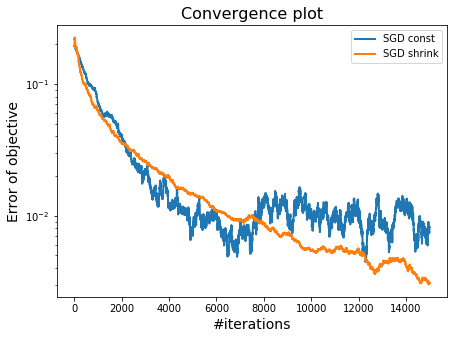

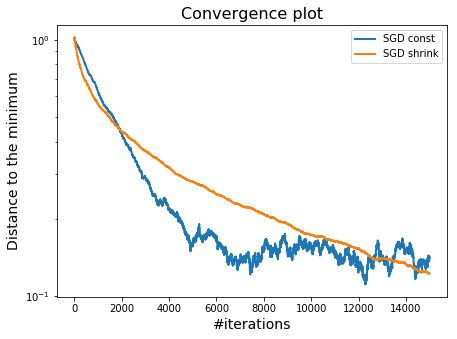

In [26]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr , label="SGD const", lw=2)
plt.semilogy(err_sgdsr , label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

**Questions**

- Compare the solution you obtain for SGD with constant stepsizes and SGD with shrinking stepsizes. 
- Which one is faster in the beginning? Which reaches the "best" solution?
- What happens when is you use sampling without replacement instead? Hint: Do only one datapass, it's annoying to adapt this implementation for more than one datapass when sampling without replacement



## 5. Compare with averaging step

- Implement the average iterate outpu  
- Compare the solution you obtain for SGD with shrinking stepsizes and SGD with averaging. 
- What happens if you start averaging only the last n iterates? When is averaging useful?


In [27]:
indices = np.random.choice(n, niters+1, replace=True)
steps = 0.005 * np.ones(niters + 1)#  0.1/ np.sqrt(np.arange(1, niters + 2))
w_sgdar, obj_sgdar, err_sgdar = sgd(w0,model, indices, steps, w_min, niters, True, True, (datapasses-5)*n)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 1.00e+00
    1000 | 5.70e-01 | 6.20e-01
    2000 | 5.32e-01 | 4.11e-01
    3000 | 5.18e-01 | 2.98e-01
    4000 | 5.11e-01 | 2.29e-01
    5000 | 5.14e-01 | 2.17e-01
    6000 | 5.07e-01 | 1.65e-01
    7000 | 5.07e-01 | 1.50e-01
    8000 | 5.03e-01 | 1.22e-01
    9000 | 5.06e-01 | 1.24e-01
   10000 | 5.07e-01 | 1.29e-01
   11000 | 5.03e-01 | 1.08e-01
   12000 | 5.02e-01 | 1.02e-01
   13000 | 5.01e-01 | 9.68e-02
   14000 | 5.00e-01 | 8.00e-02


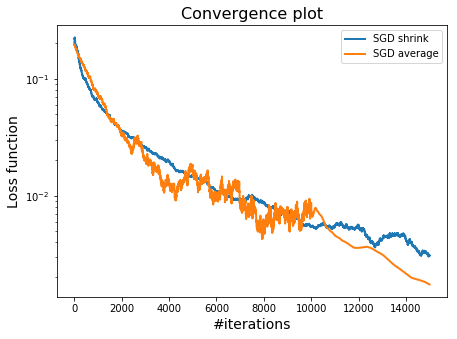

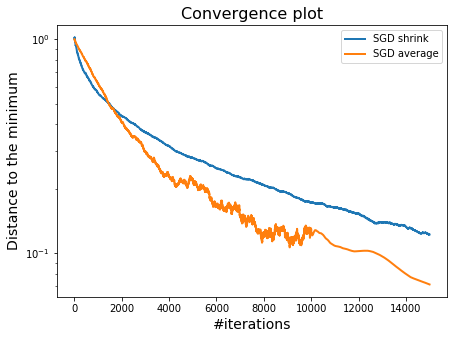

In [28]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdsr - obj_min, label="SGD shrink", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdsr , label="SGD shrink", lw=2)
plt.semilogy(err_sgdar , label="SGD average", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## Compare with gradient descent

- Complete the code of gradient descent (GD) below
- How much more is the computational cost of a step of gradient descent with respect to the computational cost of a SGD step?  How many steps of gradient descent should you take so that the total computational complexity is equivalent to datapasses * n steps of SGD ? 
- Compare GD with SGD, where on the $x$-axis of the plot you the total computational effort spent
- What happens if you increase the number of datapasses?

In [29]:
def gd(w0, model, step, w_min =[], n_iter=100, verbose=True):
    """Gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # estimation error history
    errors = []
    err = 1.
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w) 
    objectives.append(obj)
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter ):
        w[:] = w - step * model.grad(w)
        obj = model.f(w) 
        if (sum(w_min)):
            err = norm(w - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return w, np.array(objectives), np.array(errors)

In [30]:
step = 1. / model.lipschitz_constant()
w_gd, obj_gd, err_gd = gd(w0, model, step, w_min, datapasses)
print(obj_gd)

Lauching GD solver...
   it    |   obj    |   err   
       0 | 6.36e-01 | 8.69e-01
       1 | 6.00e-01 | 7.62e-01
       2 | 5.76e-01 | 6.73e-01
       3 | 5.58e-01 | 5.96e-01
       4 | 5.44e-01 | 5.31e-01
       5 | 5.34e-01 | 4.74e-01
       6 | 5.27e-01 | 4.24e-01
       7 | 5.21e-01 | 3.80e-01
       8 | 5.16e-01 | 3.42e-01
       9 | 5.13e-01 | 3.08e-01
      10 | 5.10e-01 | 2.77e-01
      11 | 5.08e-01 | 2.50e-01
      12 | 5.06e-01 | 2.26e-01
      13 | 5.04e-01 | 2.04e-01
      14 | 5.03e-01 | 1.85e-01
[ 0.69314718  0.63599968  0.60031312  0.57554345  0.55764617  0.54439719
  0.53441592  0.52679275  0.52090557  0.51631701  0.51271287  0.50986328
  0.50759757  0.50578733  0.50433489  0.50316523]


In [31]:
complexityofGD = n * np.arange(0, datapasses + 1)
print(complexityofGD)

[    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000]


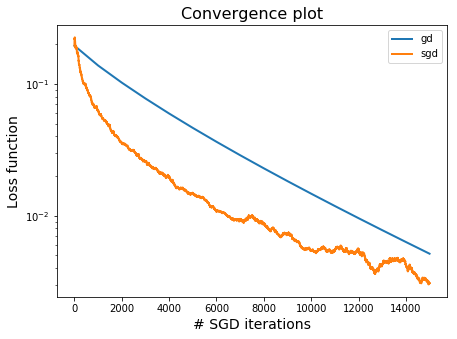

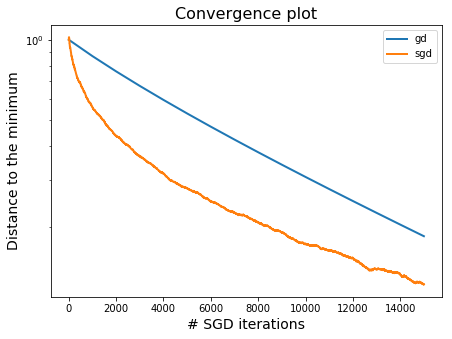

In [32]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, obj_gd - obj_min, label="gd", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="sgd", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
# Distance to the minimum on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, err_gd, label="gd", lw=2)
plt.semilogy(err_sgdsr , label="sgd", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## SGD without replacement

-Execute SGD where the indices of the data points are sampled *without* replacement over each datapass

In [33]:
import numpy.matlib
niters = int(datapasses * n) - 1
# With replacement
indices = np.matlib.repmat(np.random.choice(n, n, replace = False), 1, datapasses)
indices = indices.flatten()
###
steps = 0.1 / np.sqrt(np.arange(1, niters + 2))
w_sgdsw, obj_sgdsw, err_sgdsw = sgd(w0, model, indices, steps, w_min,niters)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 7.03e-01 | 1.00e+00
    1000 | 5.47e-01 | 5.41e-01
    2000 | 5.28e-01 | 4.28e-01
    3000 | 5.19e-01 | 3.60e-01
    4000 | 5.13e-01 | 3.12e-01
    5000 | 5.10e-01 | 2.75e-01
    6000 | 5.07e-01 | 2.46e-01
    7000 | 5.06e-01 | 2.22e-01
    8000 | 5.04e-01 | 2.03e-01
    9000 | 5.03e-01 | 1.86e-01
   10000 | 5.02e-01 | 1.71e-01
   11000 | 5.02e-01 | 1.58e-01
   12000 | 5.01e-01 | 1.47e-01
   13000 | 5.01e-01 | 1.37e-01
   14000 | 5.00e-01 | 1.28e-01


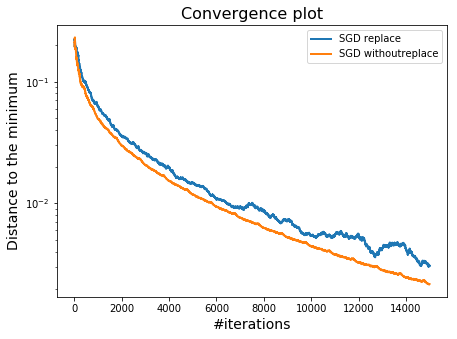

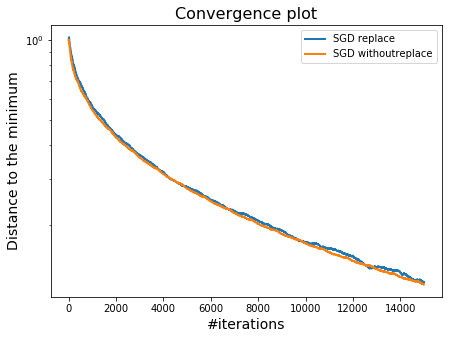

In [34]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(obj_sgdsr - obj_min, label="SGD replace", lw=2)
plt.plot(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(err_sgdsr , label="SGD replace", lw=2)
plt.plot(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
g_t \gets \frac 1n \sum_{i=1}^n J_i^t
$$
where 
$$
J_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    J_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta\, J_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [35]:
def sag(w0, model, indices,  step=1., w_min =0, n_iter=100, verbose = True): 
  #  (w0, model, indices, steps, w_min, n_iter=100, averaging_on=False ,verbose=True, start_late_averaging = 0):
    """Stochastic average gradient algorithm."""
    w = w0.copy()
    # Old gradients
    n_samples, n_features = X.shape
    gradient_memory = np.zeros((n_samples, n_features))
    averaged_gradient = np.zeros(n_features)
    # estimation error history
    errors = []
    err = 1.
    # objective history
    objectives = []
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    print("Lauching SAG solver...")
    print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))   
    for idx in range(n_iter):
        i = indices[idx]    
        ### TODO
        grad_i_new = model.grad_i(i, w)
        averaged_gradient += (grad_i_new - gradient_memory[i]) / n
        gradient_memory[i] = grad_i_new
        w[:] -= step * averaged_gradient
        ### END OF TODO
        obj = model.f(w) 
        if (sum(w_min)):
            err = norm(w - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if idx % n_samples == 0 and verbose:
            print(' | '.join([("%d" % idx).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return w, np.array(objectives), np.array(errors)

In [38]:
max_squared_sum = np.max(np.sum(X ** 2, axis=1))
SAGAstep = 0.25/ (max_squared_sum + lbda)
# With replacement
indices = np.matlib.repmat(np.random.choice(n, n, replace = False), 1, datapasses)
indices = indices.flatten()
w0 = np.zeros(d)
w_sag, obj_sag, err_sag = sag(w0, model, indices,  SAGAstep, w_min, niters)

Lauching SAG solver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 1.00e+00
    1000 | 6.43e-01 | 8.84e-01
    2000 | 5.79e-01 | 6.88e-01
    3000 | 5.47e-01 | 5.45e-01
    4000 | 5.29e-01 | 4.38e-01
    5000 | 5.18e-01 | 3.56e-01
    6000 | 5.11e-01 | 2.91e-01
    7000 | 5.07e-01 | 2.40e-01
    8000 | 5.04e-01 | 1.98e-01
    9000 | 5.02e-01 | 1.64e-01
   10000 | 5.01e-01 | 1.36e-01
   11000 | 5.00e-01 | 1.13e-01
   12000 | 4.99e-01 | 9.43e-02
   13000 | 4.99e-01 | 7.86e-02
   14000 | 4.99e-01 | 6.57e-02


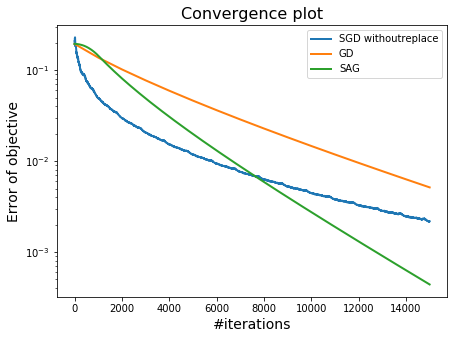

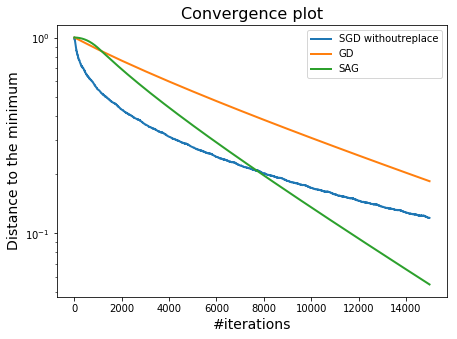

In [39]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.semilogy(complexityofGD, obj_gd - obj_min, label="GD", lw=2)
plt.semilogy(obj_sag - obj_min, label="SAG", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.semilogy(complexityofGD, err_gd , label="GD", lw=2)
plt.semilogy(err_sag , label="SAG", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

In [40]:
## Compare SGD, GD and SAG in terms of test error. That is, use w_model_truth to compare

In [43]:
datapasses = 15;
niters = int(datapasses * n)
# With replacement
indices = np.matlib.repmat(np.random.choice(n, n, replace = False), 1, datapasses)
indices = indices.flatten()
## SGD without replacement and decreasing stepsize
steps = 0.25 / np.sqrt(np.arange(1, niters + 2))
w_sgdsw, obj_sgdsw, err_sgdsw = sgd(w0,model, indices, steps, w_model_truth, niters, verbose = False);
## GD
step = 1. / model.lipschitz_constant()
w_gd, obj_gd, err_gd = gd(w0, model, step, w_model_truth, datapasses, verbose = False)
complexityofGD = n * np.arange(0, datapasses + 1)
## SAG
SAGAstep = 0.25 / (max_squared_sum + lbda)
w0 = np.zeros(d)
w_sag, obj_sag, err_sag = sag(w0, model, indices,  SAGAstep, w_model_truth, niters, verbose = False)

Lauching SAG solver...
   it    |   obj    |   err   


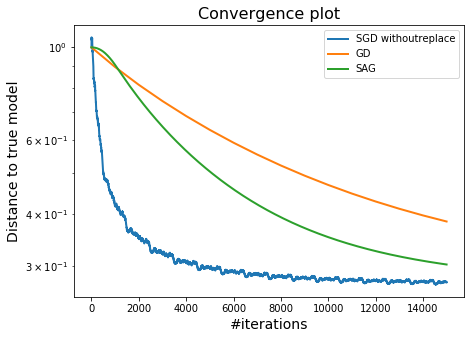

In [44]:
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.semilogy(complexityofGD, err_gd , label="GD", lw=2)
plt.semilogy(err_sag , label="SAG", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to true model", fontsize=14)
plt.legend()

## THE END!

In [294]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file

def get_data(dataname):
    data = load_svmlight_file(dataname)
    return data[0], data[1]

X, y = get_data("liver-disorders")
X = np.squeeze(np.asarray(X.todense()))
[n, d] = X.shape

In [295]:
## masking y to -1 and 1
indneg = y == min(y)
y[indneg] = -1;
y[~indneg] = 1;

In [296]:
lbda = 1. / n ** (0.5)
#model = LinReg(X, y, lbda)
model = LogReg(X, y, lbda)

In [297]:
from scipy.optimize import fmin_l_bfgs_b

w_init = np.zeros(d).T
w_min, obj_min, _ = fmin_l_bfgs_b(model.f, w_init, model.grad, args=(), pgtol=1e-30, factr =1e-30)

print(obj_min)
print(norm(model.grad(w_min)))

0.581191047273
7.96159004396775e-10


In [307]:
datapasses = 15;
w0 = np.zeros(d)
niters = int(datapasses * n)
# # With replacement
indices = np.matlib.repmat(np.random.choice(n, n, replace = False), 1, datapasses)
indices = indices.flatten()
## SGD without replacement and decreasing stepsize
steps = 0.0001 / np.sqrt(np.arange(1, niters + 2))
w_sgdsw, obj_sgdsw, err_sgdsw = sgd(w0,model, indices, steps, w_min, niters, True, True, (datapasses-5)*n);
# # GD
step = 2. / model.lipschitz_constant()
w_gd, obj_gd, err_gd = gd(w0, model, step, w_min, datapasses, verbose = True)
complexityofGD = n * np.arange(0, datapasses + 1)
## SAG
max_squared_sum = np.max(np.sum(X ** 2, axis=1))
SAGAstep = 0.5 / (max_squared_sum + lbda)
w_sag, obj_sag, err_sag = sag(w0, model, indices,  SAGAstep, w_min, niters, verbose = True)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.87e-01 | 1.01e+00
     145 | 6.22e-01 | 8.63e-01
     290 | 6.10e-01 | 8.26e-01
     435 | 6.04e-01 | 8.04e-01
     580 | 6.01e-01 | 7.89e-01
     725 | 5.98e-01 | 7.77e-01
     870 | 5.96e-01 | 7.68e-01
    1015 | 5.95e-01 | 7.60e-01
    1160 | 5.94e-01 | 7.54e-01
    1305 | 5.93e-01 | 7.48e-01
    1450 | 5.92e-01 | 7.43e-01
    1595 | 5.92e-01 | 7.40e-01
    1740 | 5.91e-01 | 7.38e-01
    1885 | 5.91e-01 | 7.36e-01
    2030 | 5.91e-01 | 7.34e-01
Lauching GD solver...
   it    |   obj    |   err   
       0 | 6.73e-01 | 9.60e-01
       1 | 6.55e-01 | 9.25e-01
       2 | 6.42e-01 | 8.97e-01
       3 | 6.31e-01 | 8.71e-01
       4 | 6.23e-01 | 8.51e-01
       5 | 6.16e-01 | 8.32e-01
       6 | 6.11e-01 | 8.17e-01
       7 | 6.06e-01 | 8.03e-01
       8 | 6.03e-01 | 7.91e-01
       9 | 6.00e-01 | 7.81e-01
      10 | 5.98e-01 | 7.72e-01
      11 | 5.96e-01 | 7.63e-01
      12 | 5.94e-01 | 7.56e-01
      13 | 5.93e-01 | 7.4

In [308]:
obj_min = min(obj_gd[-1], obj_sag[-1],  obj_sgdsw[-1], obj_min)

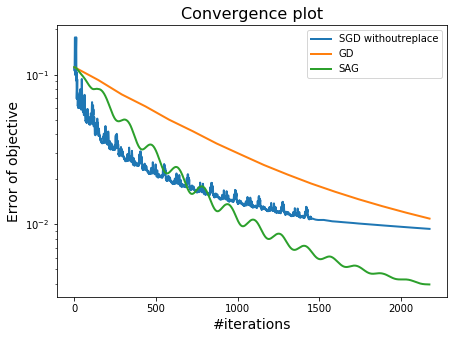

In [309]:
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.semilogy(complexityofGD, obj_gd - obj_min, label="GD", lw=2)
plt.semilogy(obj_sag - obj_min, label="SAG", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()

In [310]:
## Test error 
Xt, yt = get_data("liver-disorders.t")
Xt = np.squeeze(np.asarray(Xt.todense()))
[nt, dt] = Xt.shape

In [311]:
## masking y to -1 and 1
indneg = yt == min(yt)
yt[indneg] = -1;
yt[~indneg] = 1;

In [352]:
def Lin_class_test(w): 
      return np.mean(Xt.dot(w)*yt >=0)

In [353]:
print("SGD test: ", Lin_class_test(w_sgdsw))
print("GD test: ", Lin_class_test(w_gd))
print("SAG test: ", Lin_class_test(w_sag))

SGD test:  0.54
GD test:  0.545
SAG test:  0.56


In [293]:
# To improve the test error, scale and normalize X (and Xt accordingly), and add an affine term to the linear classifier